# Kaggle March Madness 2016

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

from __future__ import division
from __future__ import print_function

%matplotlib inline

## Load and format data

In [88]:
# load data

results = pd.read_csv('data/ncaa_geocoded_games.csv')
teams = pd.read_csv('data/Teams.csv')
kenpom = pd.read_csv('data/kenpom_sql.csv')
seeds = pd.read_csv('data/TourneySeeds.csv')

teams.columns = ['Team','Team_Name']
seeds = pd.merge(seeds, teams, how='left')
seeds.columns = ['Season','Seed','Team_id','Team_Name']

kenpom['Team'] = kenpom['Team'].str.strip()

In [89]:
def euclidean_dist(df, x1, x2, y1, y2):
    x_dist = df[x2] - df[x1]
    y_dist = df[y2] - df[y1]
    dist = np.sqrt(x_dist ** 2 + y_dist ** 2)
    return dist

## Merge matchups and external stats

In [103]:
def merge_data(team_names, matchups, stats, ljoin = ['Season','Team_Name'], rjoin = ['Year','Team']):
    merged_stats = pd.merge(team_names, stats, left_on=ljoin, right_on=rjoin)
    join1 = pd.merge(matchups, merged_stats, left_on=['Season','Wteam'], right_on=['Season','Team_id'])
    output = pd.merge(join1, merged_stats, left_on=['Season','Lteam'], right_on=['Season','Team_id'])
    
    output['Pyth_diff'] = output['Pyth_x'] - output['Pyth_y']
    output['Rank_diff'] = output['Rank_x'] - output['Rank_y']
    output['win_diff'] = output['Wins_x'] - output['Wins_y']
    output['win_pyth'] = output['Wins_x'] ** 2 / (output['Wins_x'] ** 2 + output['Wins_y'] ** 2)
    output['home_dist'] = euclidean_dist(output, 'site_long', 'team_long','site_lat','team_lat')
    output['opp_dist'] = euclidean_dist(output, 'site_long', 'opp_long','site_lat','opp_lat')
    output['ln_home_dist'] = np.log(output.home_dist + 0.1)
    output['ln_opp_dist'] = np.log(output.opp_dist + 0.1)
    output['dist_diff'] = output.home_dist - output.opp_dist
    
    output['score_diff'] = output['Wscore'] - output['Lscore']
    
    print('Matchups shape: %s' %(matchups.shape,))
    print('Merged stats shape: %s' %(merged_stats.shape,))
    print('Output shape: %s' %(output.shape,))
    
    return output

results_merged = merge_data(seeds, results.dropna(), kenpom)

columns_to_keep = ['Season','Wteam','Wscore','Lteam','Lscore','Pyth_y', 'Pyth_x'
                   ,'Luck_x', 'Luck_y' ,'Pyth_diff', 'win_diff','win_pyth'
                   ,'Rank_diff', 'Rank_x', 'Rank_y', 'Wins_x', 'Wins_y'
                   ,'AdjustD_y', 'SOS OppO_x','AdjustD_x','AdjustO_y', 'AdjustT Rank_x', 'AdjustT_y', 'AdjustT_x'
                   ,'AdjustO_x', 'SOS OppO_y', 'SOS OppD_x', 'dist_diff'
                   ,'AdjustT Rank_y','SOS OppO Rank_x','SOS OppO Rank_y', 'Luck Rank_x', 'AdjustD Rank_y','Luck Rank_y'
                   ,'AdjustD Rank_x', 'AdjustO Rank_y', 'NCSOS Pyth_x', 'SOS OppD Rank_x'
                   ,'NCSOS Pyth_y', 'AdjustO Rank_x', 'SOS OppD Rank_y', 'SOS Pyth Rank_x', 'SOS Pyth Rank_y', 'SOS OppD_y'
                   ,'NCSOS Pyth Rank_x', 'SOS Pyth_y', 'NCSOS Pyth Rank_y', 'SOS Pyth_x', 'Losses_y', 'Losses_x'
                   ,'score_diff'
                  ]


Matchups shape: (1944, 14)
Merged stats shape: (924, 28)
Output shape: (1942, 78)


## Random forest classifier

Training data shape: (1280, 45)
Training labels shape: (1280,)
Test data shape: (662, 45)
Test labels shape: (662,)

**Leaderboard rating: 0.4280**

Model accuracy of 0.807

Feature Importances:



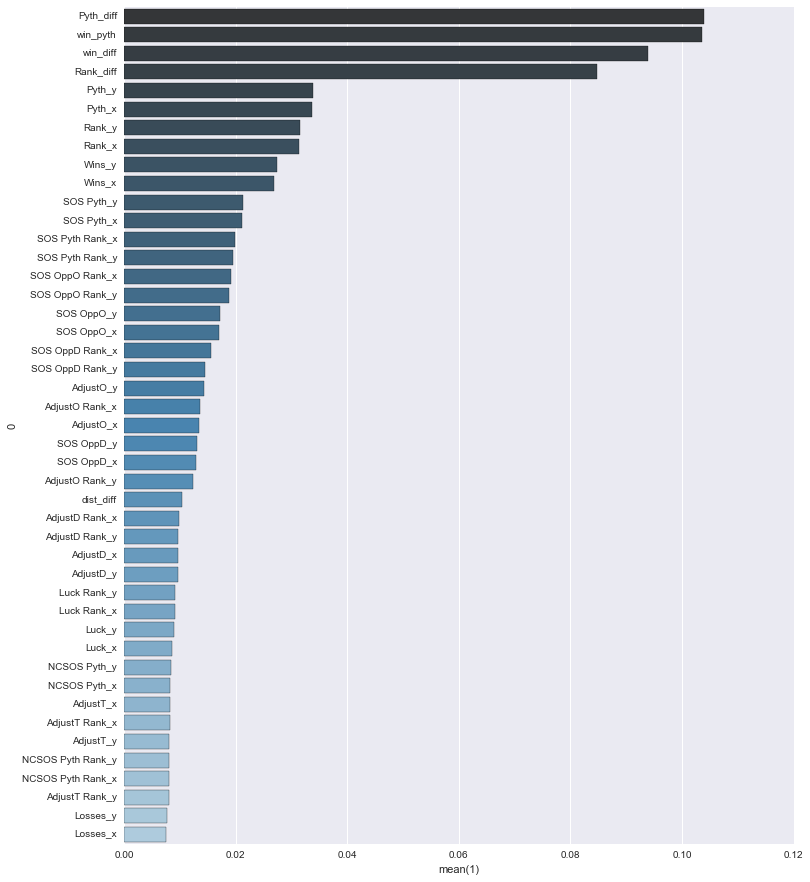

In [111]:
def prepare_datasets(raw_data, columns_keep, season_cutoff, stochastic=False):
    intermediate = raw_data[columns_keep]
    
    if stochastic:
        index = np.random.permutation(raw_data.shape[0])
        training_size = raw_data.shape[0] // 10 * 9
        
        data_for_training = intermediate.iloc[index,:]
        
        train_set = intermediate[:training_size]
        test_set = intermediate[training_size:]
        
    else:
        data_for_training = intermediate[intermediate.Season < season_cutoff]

        train_set = intermediate[intermediate.Season < season_cutoff]
        test_set = intermediate[intermediate.Season >= season_cutoff]
    
    trd = train_set.iloc[:,5:-1]
    trl = train_set.iloc[:,-1]

    ttd = test_set.iloc[:,5:-1]
    ttl = test_set.iloc[:,-1]
    
    cvd = intermediate.iloc[:,5:-1]
    cvl = intermediate.iloc[:,5-1]

    print('Training data shape: %s' %(trd.shape,))
    print('Training labels shape: %s' %(trl.shape,))
    print('Test data shape: %s' %(ttd.shape,))
    print('Test labels shape: %s' %(ttl.shape,))
    
    return trd, trl, ttd, ttl, cvd, cvl

training_data, training_labels, \
        test_data, test_labels, \
        cv_data, cv_labels = prepare_datasets(results_merged, columns_to_keep, 2012, stochastic=False)

params = {'bootstrap': True
          ,'min_samples_leaf': 7
          ,'criterion': 'entropy'
          ,'max_features': 5
          ,'max_depth': 11
          ,'n_estimators': 5000
          ,'n_jobs': -1
         }

clf = RandomForestClassifier(**params)
clf.fit(training_data, training_labels > 0)
predicted_scores = clf.predict(test_data)

predicted_probs = clf.predict_proba(test_data)

ln_odds = np.where((test_labels > 0).values, predicted_probs[:,1], 1 - predicted_probs[:,1])

print('\n**Leaderboard rating: %.4f**'%(-np.log(ln_odds).mean()))

print('\nModel accuracy of %.3f\n\nFeature Importances:\n' 
      %np.mean(predicted_scores == (test_labels > 0).values))

feat_import = sorted(zip(test_data.columns, clf.feature_importances_), key=lambda tup: tup[1], reverse=True)

plt.figure(figsize=(12,15))
ax = sns.barplot(pd.DataFrame(feat_import)[1], pd.DataFrame(feat_import)[0], orient="h", palette='Blues_d')



## Grid search for hyperparameters

In [107]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


clf = RandomForestClassifier(n_estimators=50)
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, 5, 7, 9, 11, None]
              ,"max_features": range(5, 15, 2)
              ,"min_samples_split": range(5, 15, 2)
              ,"min_samples_leaf": range(5, 15, 2)
              }

# run randomized search
random_search = GridSearchCV(clf, param_grid=param_dist,verbose=1)

start = time()
random_search.fit(cv_data, cv_labels)

report(random_search.grid_scores_)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   45.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  4.0min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:  7.1min
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed: 11.7min


Fitting 3 folds for each of 750 candidates, totalling 2250 fits
Model with rank: 1
Mean validation score: 0.061 (std: 0.012)
Parameters: {'max_features': 5, 'min_samples_split': 5, 'max_depth': 9, 'min_samples_leaf': 9}

Model with rank: 2
Mean validation score: 0.060 (std: 0.013)
Parameters: {'max_features': 5, 'min_samples_split': 11, 'max_depth': 11, 'min_samples_leaf': 7}

Model with rank: 3
Mean validation score: 0.059 (std: 0.023)
Parameters: {'max_features': 5, 'min_samples_split': 9, 'max_depth': 9, 'min_samples_leaf': 5}



[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed: 15.9min finished


In [31]:
def cross_teams(seed_list):
    teams = pd.DataFrame(seed_list[['Team_id','Season']])
    teams['key'] = 1
    
    matchups = pd.merge(teams, teams.copy(), on='key')
    matchups = matchups[matchups['Team_id_y'] > matchups['Team_id_x']]
    
    return(matchups[['Season_x','Team_id_x','Team_id_y']])

all_matchups = pd.DataFrame()

for year in np.unique(seeds.Season):
    if year > 2011:
        season_roster = seeds[seeds['Season'] == year]
        all_matchups = all_matchups.append(cross_teams(season_roster))

all_matchups.columns = ['Season_x','Team_x','Team_y']

In [32]:
matchups_merged = pd.merge(all_matchups, kenpom_merged, left_on=['Season_x','Team_x'], right_on=['Year','Team_x'])
matchups_merged = pd.merge(matchups_merged, kenpom_merged, left_on=['Season_x','Team_y_x'], right_on=['Year','Team_x'])

matchups_merged['Pyth_diff'] = matchups_merged['Pyth_x'] - matchups_merged['Pyth_y']
matchups_merged['Rank_diff'] = matchups_merged['Rank_x'] - matchups_merged['Rank_y']
    
columns_to_keep_final = ['Pyth_y', 'Pyth_x', 'Rank_x', 'Rank_y', 'Wins_x', 'Wins_y'
                    ,'AdjustD_y', 'AdjustT Rank_y','Pyth_diff','Rank_diff','AdjustD_x', 'Luck Rank_x', 'SOS OppO Rank_x'
                    ,'AdjustO_y', 'AdjustT Rank_x', 'AdjustT_y','SOS OppO Rank_y', 'Luck_x', 'AdjustD Rank_y', 'AdjustT_x'
                    ,'Luck Rank_y', 'SOS OppO_x', 'AdjustD Rank_x'
                    ,'AdjustO_x', 'NCSOS Pyth_x', 'SOS OppO_y', 'SOS OppD Rank_x', 'Luck_y', 'SOS OppD_x', 'AdjustO Rank_y'
                    ,'NCSOS Pyth_y', 'AdjustO Rank_x', 'SOS OppD Rank_y', 'SOS Pyth Rank_x', 'SOS Pyth Rank_y', 'SOS OppD_y'
                    ,'NCSOS Pyth Rank_x', 'SOS Pyth_y', 'NCSOS Pyth Rank_y', 'SOS Pyth_x', 'Losses_y', 'Losses_x'
                  ]

test_data = matchups_merged[columns_to_keep_final]
test_output = clf.predict(test_data)



NameError: name 'kenpom_merged' is not defined

Score differential distribution (mean: 0.09, sd: 10.37)


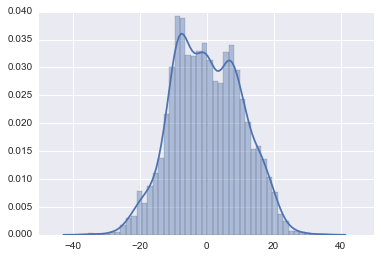

In [119]:
sns.distplot(test_output)
print(('Score differential distribution (mean: %.2f, sd: %.2f)') %(test_output.mean(), np.std(test_output)))